In [1]:
%matplotlib widget

In [2]:
import sys
sys.path.append("..")
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from data.loaders import load_capas_from_jsons, get_train_test_data, extract_capa_for_model, load_split
from catboost import CatBoostClassifier, CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm, CatBoost, Pool
from catboost.utils import get_confusion_matrix

In [3]:
parsed_capas_dir = r"C:\Users\stav\data\whodis\parsed\CAPAs"
train_test_split_dir = r'C:\Users\stav\data\whodis\train_test_split'

In [4]:
cat_dfs= load_capas_from_jsons(parsed_capas_dir)
capas_df = cat_dfs['capas']
mbcs_df = cat_dfs['mbc']
features_encoder = LabelEncoder(); features_encoder.fit(capas_df['rule'].append(mbcs_df['objective']))
capas_df['rule'] = features_encoder.transform(capas_df.rule).astype(str)
mbcs_df['objective']=features_encoder.transform(mbcs_df.objective).astype(str)

Loading json files: 100%|███████████████████████████████████████████████████████| 11075/11075 [00:56<00:00, 196.39it/s]
C:\Users\stav\AppData\Local\Temp\ipykernel_31664\922414401.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  features_encoder = LabelEncoder(); features_encoder.fit(capas_df['rule'].append(mbcs_df['objective']))


In [5]:
# Prepare features
capas_features_df = extract_capa_for_model(capas_df, column='rule')
mbcs_features_df = extract_capa_for_model(mbcs_df,column='objective')

In [6]:
features_opts = 'both' #['capas','mbc','both']
if features_opts=='both':
    features_df = pd.concat([capas_features_df,mbcs_features_df.drop(columns=['label'])],axis=1).fillna(int(0))
    feature_names = features_df.drop(columns=['label']).columns
    features_df[feature_names]=features_df[feature_names].astype(int)
elif features_opts=='capas':
    features_df = capas_features_df
elif features_opts=='mbc':
    features_df = mbcs_features_df

In [7]:
split_type= 'family_as_bg' #['flat','family_as_bg']
if split_type=='flat':
    pass
elif split_type=='family_as_bg':
    families = ['orcus', '7ev3n', 'Emotet', 'Conti', 'SugarRansomware','not_apt','missing']
    apts = ['cozy','veno']
    
    transform_dict = {f:'family' for f in families}
    for apt in apts:
        transform_dict[apt]=apt
    transform_dict['wipbot']='veno'
    features_df['label'] = features_df.label.apply(transform_dict.get)
    
label_names = features_df['label'].unique()
le = LabelEncoder()
le.fit(features_df.label)
features_df['label'] = le.transform(features_df.label)

In [12]:
split_ver = 'v3' #['v1,'v2',v3']
features_train, features_test, hard_features_test=load_split(train_test_split_dir, features_df, split_ver)
train_pool = Pool(features_train.drop(['label'], 1), 
                  label=features_train.label)
                 #cat_features=features_train.drop(columns=['label']).columns.to_list())
test_pool = Pool(features_test.drop(['label'], 1),
                 label=features_test.label)
                #cat_features=features_train.drop(columns=['label']).columns.to_list())
hard_test_pool = Pool(hard_features_test.drop(['label'], 1),
                 label=hard_features_test.label)
                #cat_features=features_train.drop(columns=['label']).columns.to_list())

C:\Users\stav\AppData\Local\Temp\ipykernel_20604\463816869.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_pool = Pool(features_train.drop(['label'], 1),
C:\Users\stav\AppData\Local\Temp\ipykernel_20604\463816869.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_pool = Pool(features_test.drop(['label'], 1),
C:\Users\stav\AppData\Local\Temp\ipykernel_20604\463816869.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  hard_test_pool = Pool(hard_features_test.drop(['label'], 1),


C:\Users\stav\AppData\Local\Temp\ipykernel_20604\397763633.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  Pool(features_train.drop(['label'], 1), label=features_train.label),
C:\Users\stav\AppData\Local\Temp\ipykernel_20604\397763633.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  eval_set=Pool(features_test.drop(['label'], 1), label=features_test.label),


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 5
0:	learn: 0.6919461	test: 0.6920429	best: 0.6920429 (0)	total: 139ms	remaining: 3m 27s
1:	learn: 0.6909035	test: 0.6910003	best: 0.6910003 (1)	total: 140ms	remaining: 1m 44s
2:	learn: 0.6898809	test: 0.6899776	best: 0.6899776 (2)	total: 140ms	remaining: 1m 10s
3:	learn: 0.6888777	test: 0.6889744	best: 0.6889744 (3)	total: 141ms	remaining: 52.8s
4:	learn: 0.6878937	test: 0.6879903	best: 0.6879903 (4)	total: 142ms	remaining: 42.5s
5:	learn: 0.6869283	test: 0.6870249	best: 0.6870249 (5)	total: 143ms	remaining: 35.6s
6:	learn: 0.6859814	test: 0.6860778	best: 0.6860778 (6)	total: 144ms	remaining: 30.7s
7:	learn: 0.6850524	test: 0.6851488	best: 0.6851488 (7)	total: 145ms	remaining: 27s
8:	learn: 0.6841410	test: 0.6842374	best: 0.6842374 (8)	total: 145ms	remaining: 24.1s
9:	learn: 0.6832469	test: 0.6833432	best: 0.6833432 (9)	total: 146ms	remaining: 21.8s
10:	learn: 0.6823708	test: 0.6824668	best: 0.6824668 (10)	total: 149ms	remaining: 20.2s
11:	learn: 0.6815102	test: 0.68160

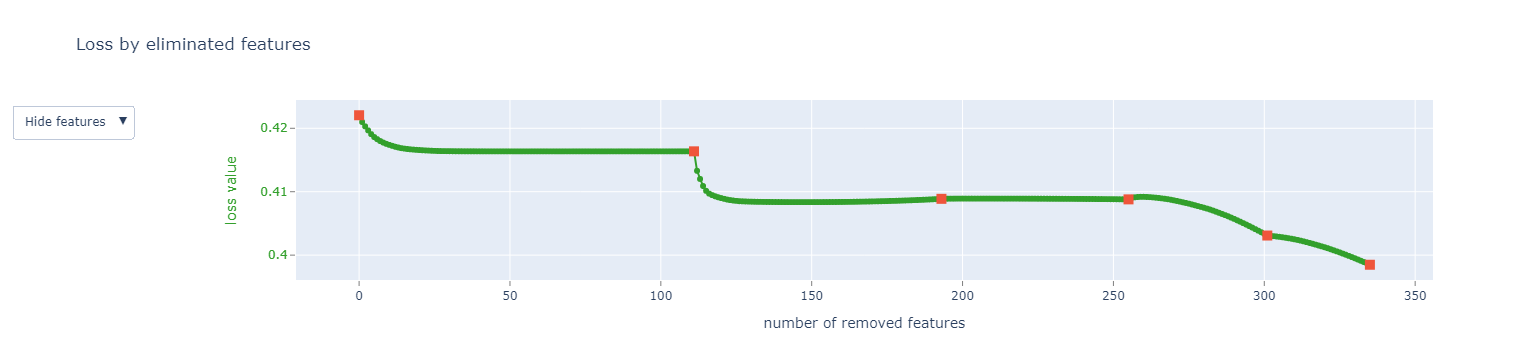

In [13]:
model_params_featur_select1 = dict(iterations=1500, learning_rate=0.01, auto_class_weights='Balanced', reg_lambda=20.0, grow_policy='Lossguide', 
                    depth=6, max_leaves=16, colsample_bylevel=0.5, loss_function='MultiClassOneVsAll')

selection_steps = 5
model_selected1 = CatBoostClassifier(**model_params_featur_select1)
summary1 = model_selected1.select_features(
         Pool(features_train.drop(['label'], 1), label=features_train.label),
        eval_set=Pool(features_test.drop(['label'], 1), label=features_test.label),
        features_for_select=features_train.drop(columns=['label']).columns.to_list(),     # we will select from all features
        num_features_to_select=100,  # we want to select exactly important features
        steps=selection_steps,                                     # more steps - more accurate selection
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        plot=True
    )
selected_features = summary1['selected_features_names']


In [14]:
X_train = features_train[selected_features]
y_train = features_train.label
X_test = features_test[selected_features]
y_test = features_test.label
X_test_hard = hard_features_test[selected_features]
y_test_hard = hard_features_test.label

In [23]:
print('Test Accuracy (Easy) {}'.format(((model_selected1.predict(X_test))==y_test[:,np.newaxis]).sum()/y_test.shape[0]))
print('Test Accuracy (hard) {}'.format((model_selected1.predict(X_test_hard)==y_test_hard[:,np.newaxis]).sum()/y_test_hard.shape[0]))
cm = get_confusion_matrix(model_selected1, test_pool)
print(cm)

Test Accuracy (Easy) 0.7475845410628019
Test Accuracy (hard) 0.6
[[ 30.   5.   3.]
 [ 50. 472. 115.]
 [  4.  32. 117.]]


C:\Users\stav\AppData\Local\Temp\ipykernel_20604\3303634171.py:1: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

C:\Users\stav\AppData\Local\Temp\ipykernel_20604\3303634171.py:2: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



In [20]:
model_selected1.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
)

In [24]:
shap_values = model_selected1.get_feature_importance(Pool(X_test, y_test), type="ShapValues")

In [25]:
feature_names = features_encoder.inverse_transform([int(x) for x in X_test.columns])
label_names = le.inverse_transform([0,1,2])

In [27]:
import shap
shap.initjs()

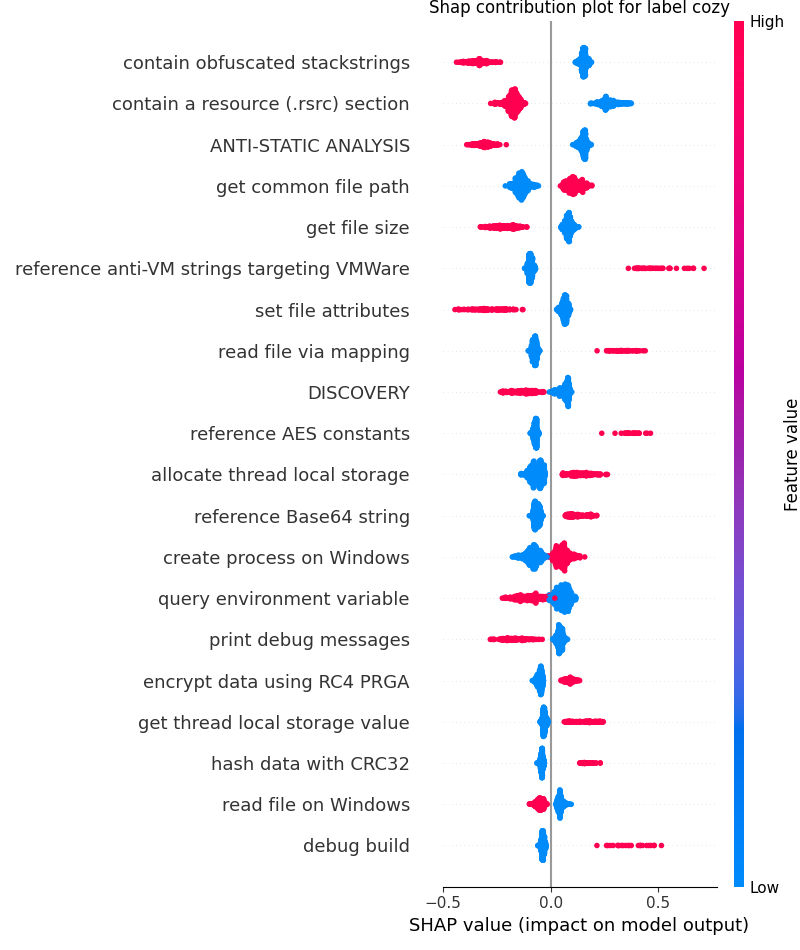

In [35]:
plt.figure()
shap.summary_plot(shap_values.transpose(1,0,2)[0,:,:-1], X_test.values,feature_names=feature_names,show=False)
plt.title(f'Shap contribution plot for label {label_names[0]}')
plt.show()

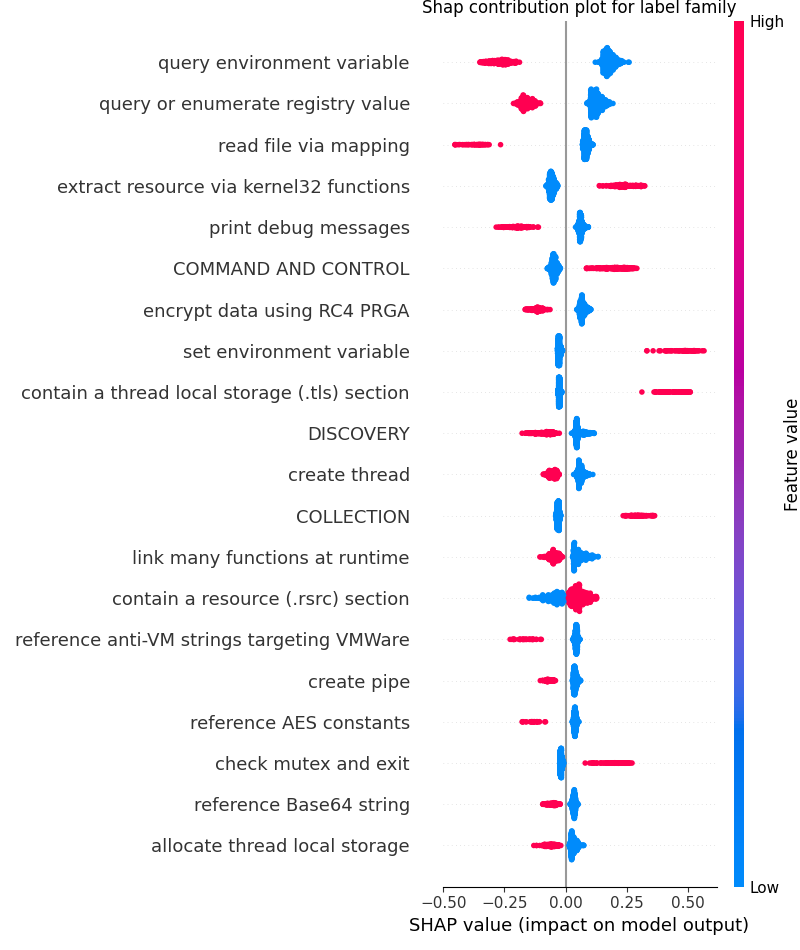

In [36]:
plt.figure()
shap.summary_plot(shap_values.transpose(1,0,2)[1,:,:-1], X_test.values,feature_names=feature_names,show=False)
plt.title(f'Shap contribution plot for label {label_names[1]}')
plt.show()

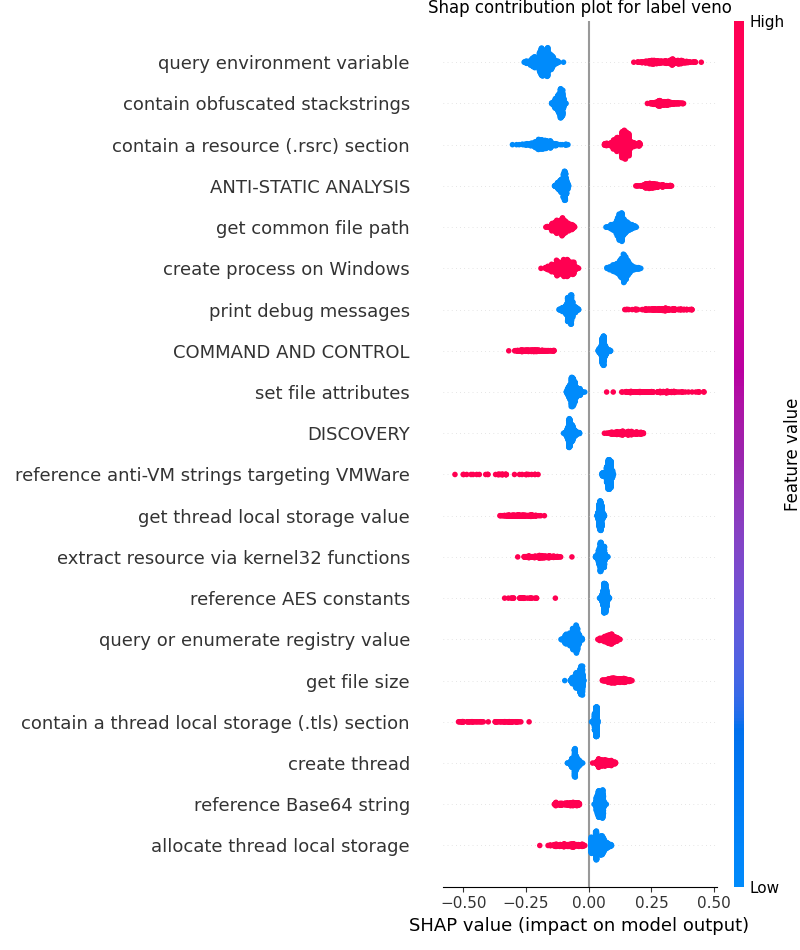

In [37]:
plt.figure()
shap.summary_plot(shap_values.transpose(1,0,2)[2,:,:-1], X_test.values,feature_names=feature_names,show=False)
plt.title(f'Shap contribution plot for label {label_names[2]}')
plt.show()

In [39]:
model_params_featur_select2 = dict(iterations=1500, learning_rate=0.01, auto_class_weights='Balanced', reg_lambda=20.0, grow_policy='Lossguide', 
                    depth=6, max_leaves=16, colsample_bylevel=0.5, loss_function='MultiClassOneVsAll')

selection_steps = 5
model_selected2 = CatBoostClassifier(**model_params_featur_select1)
summary1 = model_selected2.select_features(
         Pool(features_train.drop(['label'], 1), label=features_train.label),
        eval_set=Pool(features_test.drop(['label'], 1), label=features_test.label),
        features_for_select=features_train.drop(columns=['label']).columns.to_list(),     # we will select from all features
        num_features_to_select=50,  # we want to select exactly important features
        steps=selection_steps,                                     # more steps - more accurate selection
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        plot=True
    )
selected_features = summary1['selected_features_names']

In [40]:
X_train = features_train[selected_features]
y_train = features_train.label
X_test = features_test[selected_features]
y_test = features_test.label
X_test_hard = hard_features_test[selected_features]
y_test_hard = hard_features_test.label

In [41]:
model_selected2.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
)

In [ ]:
print('Test Accuracy (Easy) {}'.format(((model_selected2.predict(X_test))==y_test[:,np.newaxis]).sum()/y_test.shape[0]))
print('Test Accuracy (hard) {}'.format((model_selected2.predict(X_test_hard)==y_test_hard[:,np.newaxis]).sum()/y_test_hard.shape[0]))
cm = get_confusion_matrix(model_selected1, test_pool)
print(cm)

In [2]:
# Ignore Features

ignore_features=['move file']
ignore_features_encoded = features_encoder.transform(ignore_features).astype(str)
split_ver = 'v3' #['v1,'v2',v3']
features_train, features_test, hard_features_test=_load_split(features_df.drop(columns=ignore_features_encoded), split_ver)

NameError: name 'features_encoder' is not defined

In [ ]:
model_params_featur_select2 = dict(iterations=1500, learning_rate=0.01, auto_class_weights='Balanced', reg_lambda=20.0, grow_policy='Lossguide', 
                    depth=6, max_leaves=16, colsample_bylevel=0.5, loss_function='MultiClassOneVsAll')

selection_steps = 5
model2 = CatBoostClassifier(**model_params_featur_select1)
summary = {}
summary['selected_features_names'] = features_train.drop(columns=['label']).columns.to_list()
summary = model2.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=features_train.drop(columns=['label']).columns.to_list(),     # we will select from all features
        num_features_to_select=100,  # we want to select exactly important features
        steps=selection_steps,                                     # more steps - more accurate selection
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        plot=True
    )